In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from dataclasses import dataclass

sns.set_theme()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['grid.alpha'] = 0.3

In [2]:
data = pd.read_csv('../data/aapl_5m_train.csv')

rsi_indicator = ta.momentum.RSIIndicator(close=data['Close'], window=15)
data['rsi'] = rsi_indicator.rsi()

data['buy_signal'] = data['rsi'] < 20
data['sell_signal'] = data['rsi'] > 80

data = data.dropna()

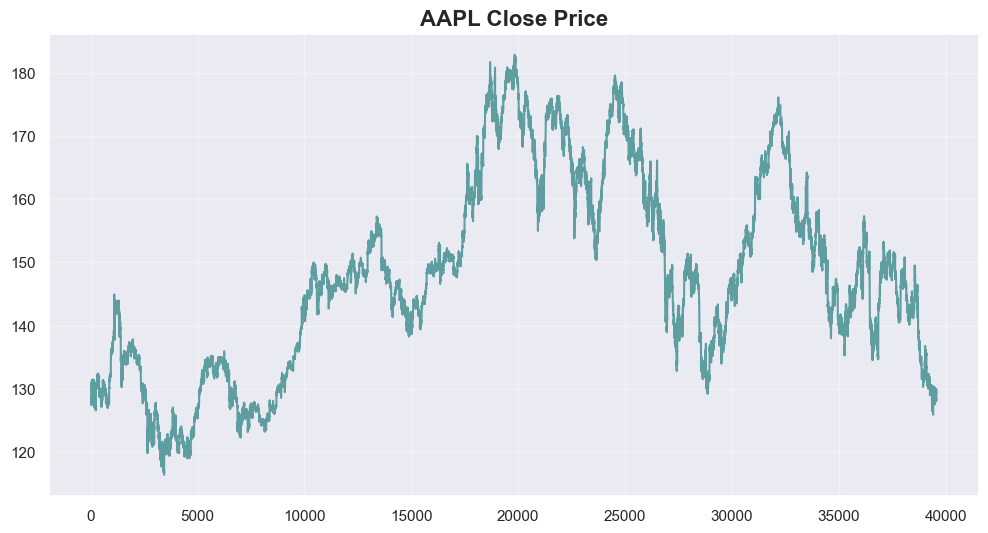

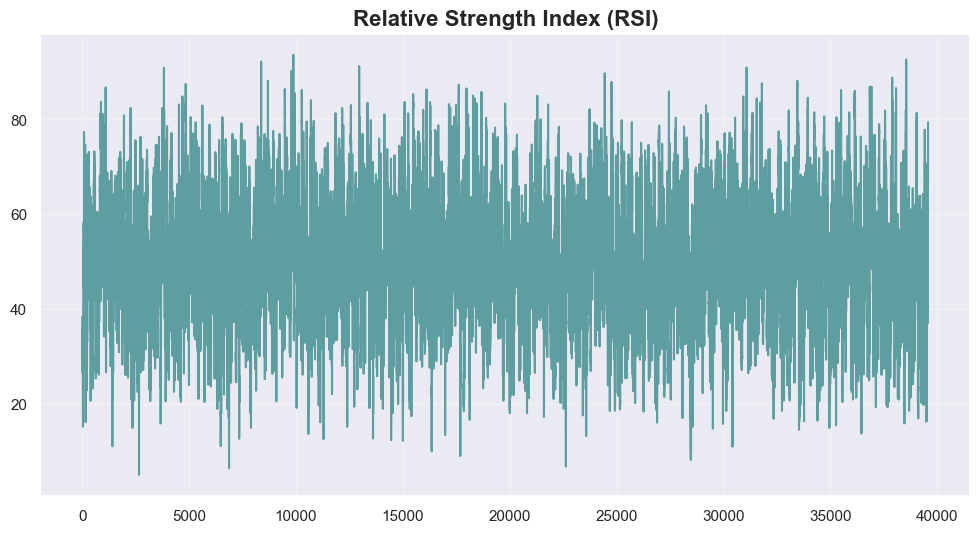

In [3]:
plt.figure()
plt.plot(data['Close'], label='AAPL', color='cadetblue')
plt.title('AAPL Close Price')
plt.show()

plt.figure()
plt.plot(data['rsi'], label='RSI', color='cadetblue')
plt.title('Relative Strength Index (RSI)')
plt.show()

# Supuestos

+ Comisión = 0.125%
+ No hay impuestos
+ No apalancamiento
+ Cuenta Margen = 50%
+ Capital = 1,000,000
+ N Shares = 50
+ Stop Loss / Take Profit = 6%
+ Trades at Close
+ Borrow Rate 0.25% anual

Dado que se tienen datos con intervalos de 5 minutos, hay que ajustar la tasa del borrow rate a la frecuencia de los datos. Por lo tanto, hay 252 dias habiles de trade en el año, donde cada día abre 6.5 horas. Entonces por día habría $60*6.5=390$ minutos por día, dando un total de $390/5=78$ ventanas de 5 minutos por día y un total de $78*252=19,656$ Ventanas de 5 minutos en un año. La manera de ajustarla sería:

$$
\text{BR}_{5m} = \frac{\text{BR}_{anual}}{19,656} = \frac{0.25\%}{19,656} = 0.0000127188\%
$$

In [4]:
COM = 0.125/100

#DOF (Grados de libertad)
STOP_LOSS = 0.10
TAKE_PROFIT = 0.10
N_SHARES = 50

capital = 1_000_000

margin_account = 50/100
maint_margin = 25/100 #***NO DEFINIDO EN CLASE***
BORROW_RATE=0.25/100 #Actual borrow for Apple stock
ADJ_BORROW_RATE = BORROW_RATE / 19_656

In [5]:
@dataclass
class Position:
    """
    Represents a trading position.
    """
    ticker: str        # Stock ticker symbol
    n_shares: int      # Number of shares in the position
    price: float       # Entry price of the position
    sl: float          # Stop-loss price
    tp: float          # Take-profit price
    time: str          # Time when the position was opened
    pos_type: 'str'    # Type of position (long/short)
    proceeds: float    # Proceeds from the position if short


# Function to calculate portfolio value
def get_portfolio_value(capital, long_positions, short_positions, current_price, n_shares):
    # Long positions are valued at current market price
    value = capital
    value += len(long_positions) * n_shares * current_price

    for position in short_positions.copy():
        value += position.proceeds + (position.price - current_price) * n_shares
        
    return value


# Function to print results
def print_results(capital, initial_capital, portfolio_values):
    print('------ Bactesting Results ------')
    print('********************************\n')

    print(f'RSI Limits: Buy below 20, Sell above 80')
    print(f'Commission per trade: {COM*100:.3f}%')
    print(f'Stop Loss: {STOP_LOSS*100:.2f}%')
    print(f'Take Profit: {TAKE_PROFIT*100:.2f}%')
    print(f'Number of Shares per Trade: {N_SHARES}')
    print(f'Margin Account Requirement: {margin_account*100:.2f}%')
    print(f'Maintenance Margin Requirement: {maint_margin*100:.2f}%')
    print(f'Annual Borrow Rate: {BORROW_RATE*100:.3f}%')
    print(f'Adjusted Borrow Rate per 5 min: {ADJ_BORROW_RATE*100:.6f}%\n')

    print(f'Initial Capital: {initial_capital:,.2f}')
    print(f'Final Capital: {capital:,.2f}')
    print(f'Net Profit: {capital - initial_capital:,.2f}')
    print(f'Return on Investment: {(capital - initial_capital) / initial_capital * 100:,.2f}%')
    print('\n********************************')
    print('--------------------------------')

    plt.figure()
    plt.plot(portfolio_values, label='Portfolio Value', color='cadetblue')
    plt.title('Portfolio Value Over Time')
    plt.show()

------ Bactesting Results ------
********************************

RSI Limits: Buy below 20, Sell above 80
Commission per trade: 0.125%
Stop Loss: 10.00%
Take Profit: 10.00%
Number of Shares per Trade: 50
Margin Account Requirement: 50.00%
Maintenance Margin Requirement: 25.00%
Annual Borrow Rate: 0.250%
Adjusted Borrow Rate per 5 min: 0.000013%

Initial Capital: 1,000,000.00
Final Capital: 3,527,097.05
Net Profit: 2,527,097.05
Return on Investment: 252.71%

********************************
--------------------------------


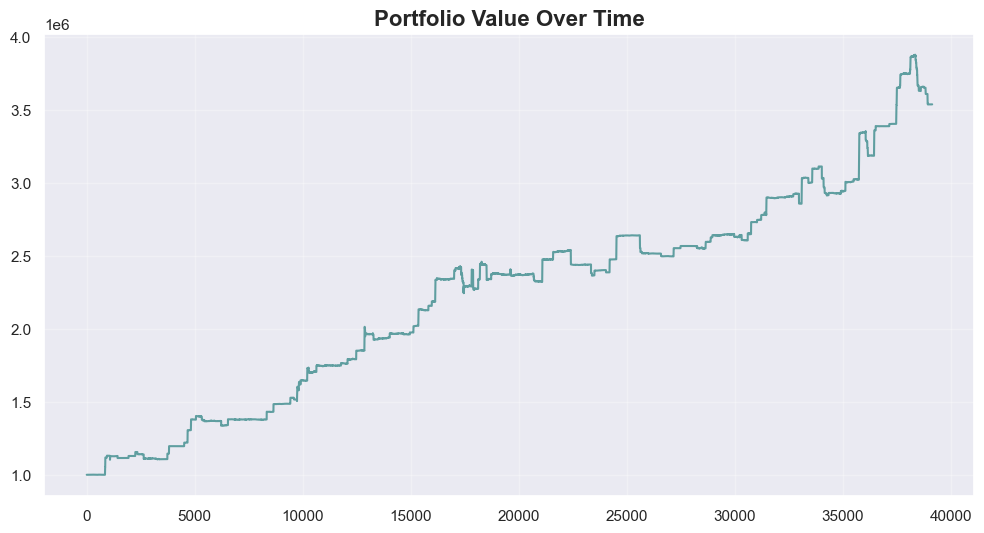

In [6]:
active_long_positions: list[Position] = []
active_short_positions: list[Position] = []
portfolio_values = []

# Start Backtesting
for i, row in data.iterrows():
    """ 1
    ---- LONG ACTIVE ORDERS ----
    """
    for position in active_long_positions.copy():
        # Stop Loss or take profit Check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1 - COM)
            #Remove position from active positions
            active_long_positions.remove(position)

    """ 2
    ---- SHORT ACTIVE ORDERS ---- 
    """
    for position in active_short_positions.copy():
        # Calculate borrow cost for each 5 min period
        borrow_cost = position.price * position.n_shares * ADJ_BORROW_RATE
        capital -= borrow_cost

        # Short Position Equity
        current_buy_to_cover_cost = row.Close * position.n_shares * (1 + COM)
        equity = capital + position.proceeds - current_buy_to_cover_cost

        # Stop Loss or take profit Check
        if row.Close < position.tp or row.Close > position.sl:
            # Add profits / losses to capital
            pnl = position.proceeds - current_buy_to_cover_cost
            capital += pnl
            #Remove position from active positions
            active_short_positions.remove(position)
            continue

        # Margin Call Check
        maintenance_req = maint_margin * position.price * position.n_shares # Capital required to maintain position
        # If equity is less than maintenance requirement, a margin call is issued and we need to add capital
        if equity < maintenance_req:
            margin_needed = maintenance_req - equity
            # If we have enough capital, we add it to the position
            if capital >= margin_needed:
                capital -= margin_needed
            # If we don't have enough capital the position is forced to close
            else:
                pnl = position.proceeds - current_buy_to_cover_cost
                capital += pnl
                active_short_positions.remove(position)
                continue

    
    """ 3
    ---- LONG ENTRY ----
    """
    #  Check Signal
    if row.buy_signal:
        cost = row.Close * N_SHARES * (1 + COM)
        # Do we have enough capital cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(
                ticker = 'AAPL',
                n_shares = N_SHARES,
                price = row['Close'],
                sl = row['Close'] * (1 - STOP_LOSS),
                tp = row['Close'] * (1 + TAKE_PROFIT),
                time = row['Datetime'],
                pos_type = 'long',
                proceeds = 0
            )
            active_long_positions.append(pos)
    
    """ 4
    ---- SHORT ENTRY ----
    """
    # Check Signal
    if row.sell_signal:
        req_margin = row.Close * N_SHARES * margin_account
        borrow_cost = row.Close * N_SHARES * ADJ_BORROW_RATE
        margin_acc_cost = req_margin + borrow_cost
        # Do we have enough capital?
        if capital > margin_acc_cost:
            short_proceed = row.Close * N_SHARES * (1 - COM)
            # Add proceeds from short sale and subtract borrow cost
            capital += short_proceed
            capital -= borrow_cost
            # Add position to portfolio
            pos = Position(
                ticker = 'AAPL',
                n_shares = N_SHARES,
                price = row['Close'],
                sl = row['Close'] * (1 + STOP_LOSS),
                tp = row['Close'] * (1 - TAKE_PROFIT),
                time = row['Datetime'],
                pos_type = 'short',
                proceeds = short_proceed
            )
            active_short_positions.append(pos)

    # Calculate and store portfolio value
    portfolio_value = get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES)
    portfolio_values.append(portfolio_value)


#At the end of the backtesting, we should close all active positions
# LONG POSITIONS
capital += row.Close * len(active_long_positions)*N_SHARES * (1-COM)
active_long_positions = []

# SHORT POSITIONS
for position in active_short_positions.copy():
    cost_to_cover = row.Close * N_SHARES * (1 + COM)
    pnl = position.proceeds - cost_to_cover
    capital += pnl
active_short_positions = []

print_results(capital, 1_000_000, portfolio_values)